### 2.Reproduce  the  exercises  about  time  series  analysis  done  in  class  using  Python  and  do  the following:
    a.Take the Superstore.xlsdataset, select the furniture department, do data preparation of furniture sales, visualize the time series, do ARIMA modeling and forecasting, validate the results, and conclude with an analysisincluding your own comments 
    b.Select the Office supply department, do the same exercise as with furniture sales, compare the results, and include your own comments



In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Time series analysis comprises methods for analyzing time series data in 
# order to extract meaningful statistics and other characteristics of the data.
#  Time series forecasting is the use of a model to predict future values 
# based on previously observed values.
# Time series are widely used for non-stationary data, like economic, 
# weather, stock price, and retail sales in this post. We will demonstrate 
# different approaches for forecasting retail sales time series. 
# Let’s get started!

# The Data
# We are using Superstore sales data that can be downloaded from here.

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [9]:
# There are several categories in the Superstore sales data, we start from 
# time series analysis and forecasting for furniture sales.
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

# We have a good 4-year furniture sales data.
furniture['Order Date'].min(), furniture['Order Date'].max()



(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [10]:
# Data Preprocessing
# This step includes removing columns we do not need, check missing values, 
# aggregate sales by date and so on.
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing with Time Series Data
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

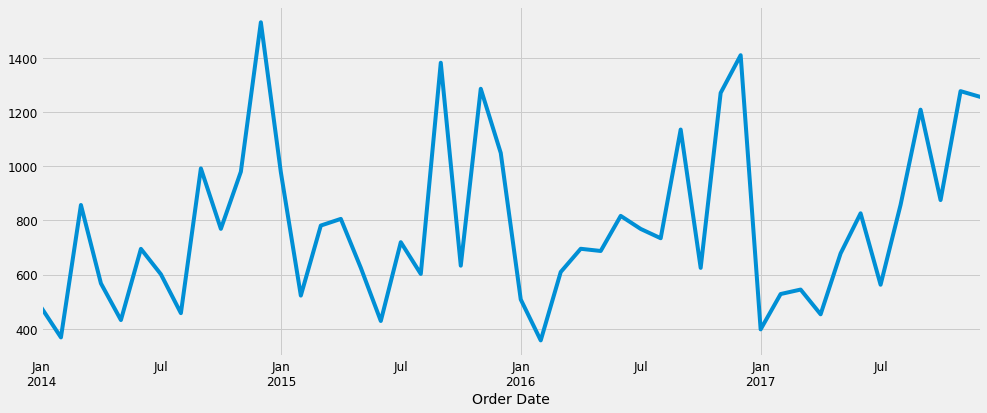

In [5]:
# Our current datetime data can be tricky to work with, therefore, we will 
# use the averages daily sales value for that month instead, and we are 
# using the start of each month as the timestamp.
y = furniture['Sales'].resample('MS').mean()

# Have a quick peek 2017 furniture sales data.
y['2017':]

# Visualizing Furniture Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

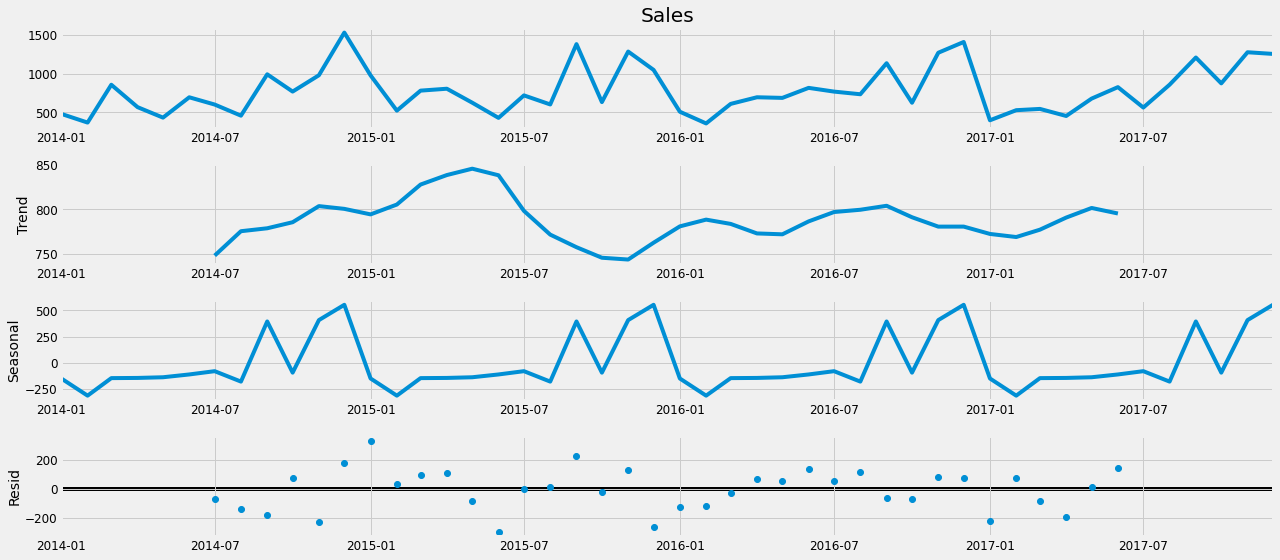

In [6]:
# Some distinguishable patterns appear when we plot the data. The time-series 
# has seasonality pattern, such as sales are always low at the beginning of 
# the year and high at the end of the year. There is always an upward trend 
# within any single year with a couple of low months in the mid of the year.
# We can also visualize our data using a method called time-series decomposition
# that allows us to decompose our time series into three distinct components: 
# trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# The plot above clearly shows that the sales of furniture is unstable, 
# along with its obvious seasonality.

In [7]:
# ----------------------------------------------------------------------------
# Time series forecasting with ARIMA
# We are going to apply one of the most commonly used method for time-series 
# forecasting, known as ARIMA, which stands for 
# Autoregressive Integrated Moving Average.
# ARIMA models are denoted with the notation ARIMA(p, d, q). 
# These three parameters account for seasonality, trend, and noise in data:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [8]:
# This step is parameter Selection for our furniture’s sales 
# ARIMA Time Series Model. Our goal here is to use a “grid search” 
# to find the optimal set of parameters that yields the best 
# performance for our model.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                            continue  

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1433.9737757428065
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997937896
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1131.1862176527952
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280302272
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758111
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2677.925835775167
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091534
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673282
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5535926556869
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.2838482013117
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.87255765197665
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1508.9267328194878
ARI

In [9]:
# The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the 
# lowest AIC value of 297.78. Therefore we should consider this 
# to be optimal option.
# Fitting the ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


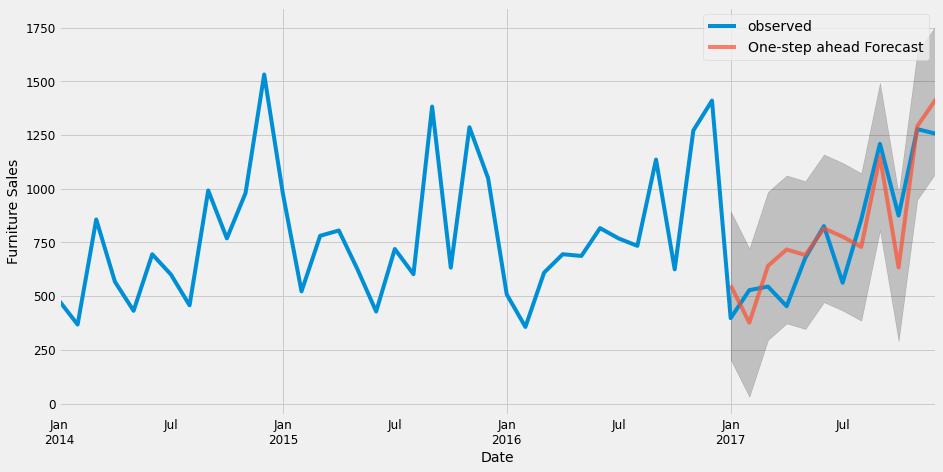

In [10]:
# We should always run model diagnostics to investigate any unusual behavior.

# It is not perfect, however, our model diagnostics suggests that the model 
# residuals are near normally distributed.

# Validating forecasts
# To help us understand the accuracy of our forecasts, we compare 
# predicted sales to real sales of the time series, and we set forecasts 
# to start at 2017–01–01 to the end of the data.
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [11]:
# The line plot is showing the observed values compared to the rolling 
# forecast predictions. Overall, our forecasts align with the true values 
# very well, showing an upward trend starts from the beginning of the 
# year and captured the seasonality toward the end of the year.
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 22993.58
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# The Root Mean Squared Error of our forecasts is 151.64

The Mean Squared Error of our forecasts is 22993.56
The Root Mean Squared Error of our forecasts is 151.64


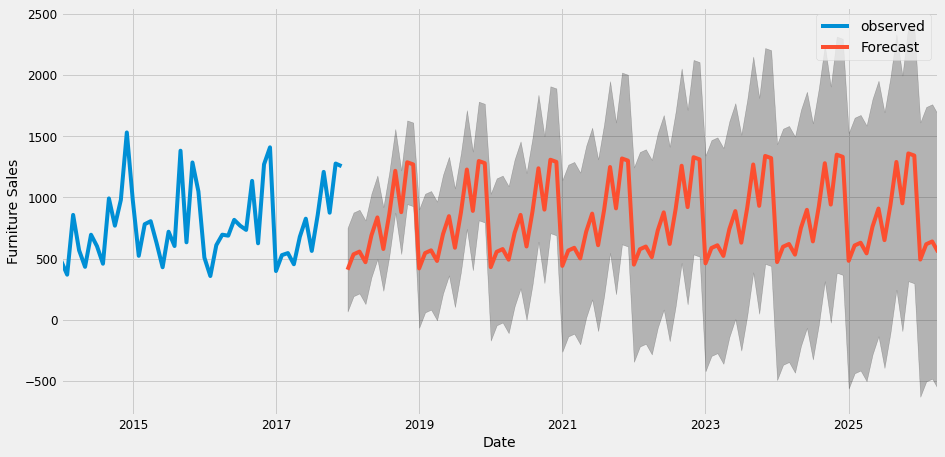

In [12]:
# In statistics, the mean squared error (MSE) of an estimator measures the 
# average of the squares of the errors — that is, the average squared 
# difference between the estimated values and what is estimated. 
# The MSE is a measure of the quality of an estimator — it is always 
# non-negative, and the smaller the MSE, the closer we are to finding the 
# line of best fit.
# Root Mean Square Error (RMSE) tells us that our model was able to forecast 
# the average daily furniture sales in the test set within 151.64 of 
# the real sales. Our furniture daily sales range from around 400 to over 1200.
#  In my opinion, this is a pretty good model so far.

# Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [13]:
# Our model clearly captured furniture sales seasonality. As we forecast 
# further out into the future, it is natural for us to become less confident 
# in our values. This is reflected by the confidence intervals generated 
# by our model, which grow larger as we move further out into the future.
# The above time series analysis for furniture makes me curious about 
# other categories, and how do they compare with each other over time. 
# Therefore, we are going to compare time series 
# of furniture and office supplier.

# --------------------------------------------------------------------------
# Time Series of Furniture vs. Office Supplies
# According to our data, there were way more number of sales from Office 
# Supplies than from Furniture over the years.
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [14]:
# Data Exploration
# We are going to compare two categories’ sales in the same time period. 
# This means combine two data frames into one and plot these 
# two categories’ time series into one plot.
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


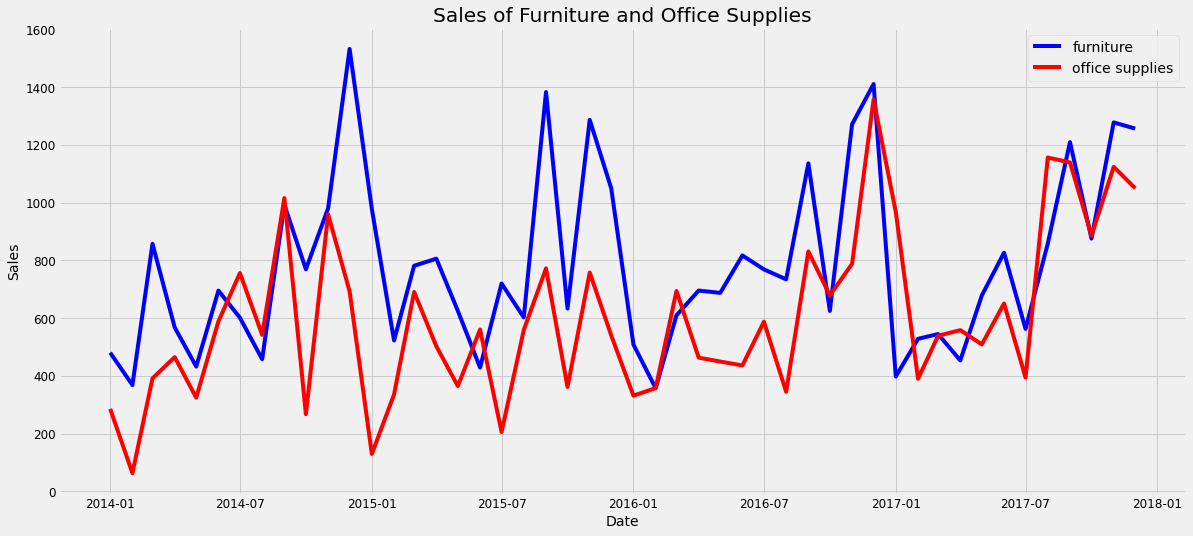

In [15]:
# plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

# We observe that sales of furniture and office supplies shared a similar 
# seasonal pattern. Early of the year is the off season for both of the 
# two categories. It seems summer time is quiet for office supplies too. 
# in addition, average daily sales for furniture are higher than those of 
# office supplies in most of the months. It is understandable, as the value 
# of furniture should be much higher than those of office supplies. 
# Occasionally, office supplies passed furniture on average daily sales. 
# Let’s find out when was the first time office supplies’ sales surpassed 
# those of furniture’s.
# first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
# print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

# Office supplies first time produced higher sales than furniture is 2014–07–01.
# It was July 2014!



##  c.Do the same exercise using Facebooks’sProphet time series analysis library. https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [23]:
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b


# Time series analysis comprises methods for analyzing time series data in 
# order to extract meaningful statistics and other characteristics of the data.
#  Time series forecasting is the use of a model to predict future values 
# based on previously observed values.
# Time series are widely used for non-stationary data, like economic, 
# weather, stock price, and retail sales in this post. We will demonstrate 
# different approaches for forecasting retail sales time series. 
# Let’s get started!


# -------------------------------------------------------------------------
# Time Series Modeling with Prophet
# Released by Facebook in 2017, forecasting tool Prophet is designed for 
# analyzing time-series that display patterns on different time scales such 
# as yearly, weekly and daily. It also has advanced capabilities for modeling 
# the effects of holidays on a time-series and implementing custom changepoints.
#  Therefore, we are using Prophet to get a model up and running.

# bash

#conda install gcc 
#conda install -c conda-forge fbprophet

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from fbprophet import Prophet

In [3]:
# The Data
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

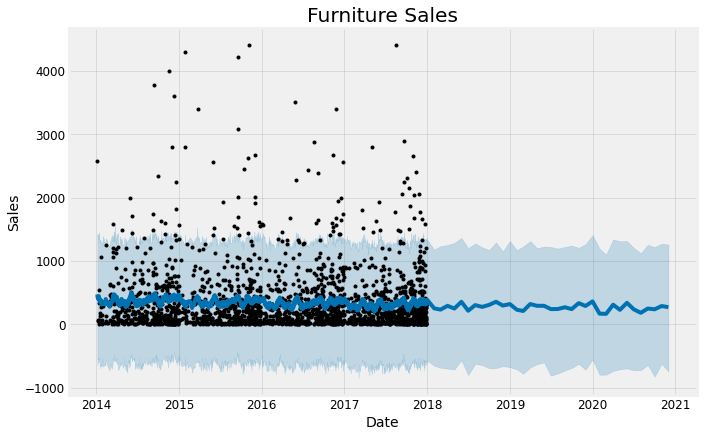

<Figure size 1296x432 with 0 Axes>

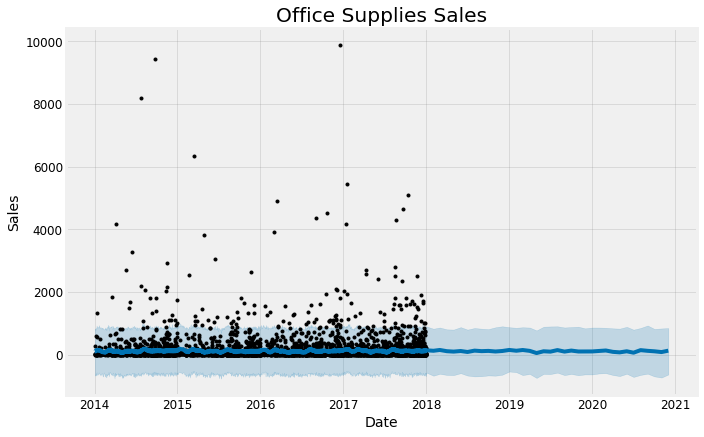

In [4]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

In [11]:
# Compare Forecasts
# We already have the forecasts for three years for these two categories into 
# the future. We will now join them together to compare their future forecasts.
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_weekly,...,office_weekly,office_weekly_lower,office_weekly_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-06,390.152885,-530.730575,1411.965455,390.152885,390.152885,82.815417,82.815417,82.815417,26.351040,...,5.206828,5.206828,5.206828,26.796555,26.796555,26.796555,0.0,0.0,0.0,121.832528
1,2014-01-07,390.095031,-652.365529,1387.034505,390.095031,390.095031,33.764800,33.764800,33.764800,-20.581214,...,20.004828,20.004828,20.004828,29.414218,29.414218,29.414218,0.0,0.0,0.0,139.440435
2,2014-01-10,389.921470,-524.793069,1432.516750,389.921470,389.921470,47.208058,47.208058,47.208058,3.759501,...,4.767567,4.767567,4.767567,37.133646,37.133646,37.133646,0.0,0.0,0.0,132.499338
3,2014-01-13,389.747908,-523.138141,1453.687084,389.747908,389.747908,52.703226,52.703226,52.703226,26.351040,...,5.206828,5.206828,5.206828,43.716183,43.716183,43.716183,0.0,0.0,0.0,140.097873
4,2014-01-16,389.574347,-572.996895,1297.058120,389.574347,389.574347,9.085773,9.085773,9.085773,3.945105,...,0.473201,0.473201,0.473201,47.865541,47.865541,47.865541,0.0,0.0,0.0,140.090339


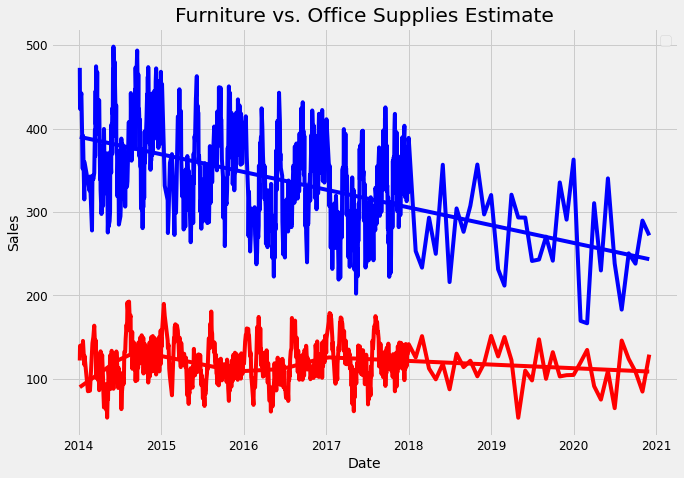

In [5]:
# Trend and Forecast Visualization
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

# plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

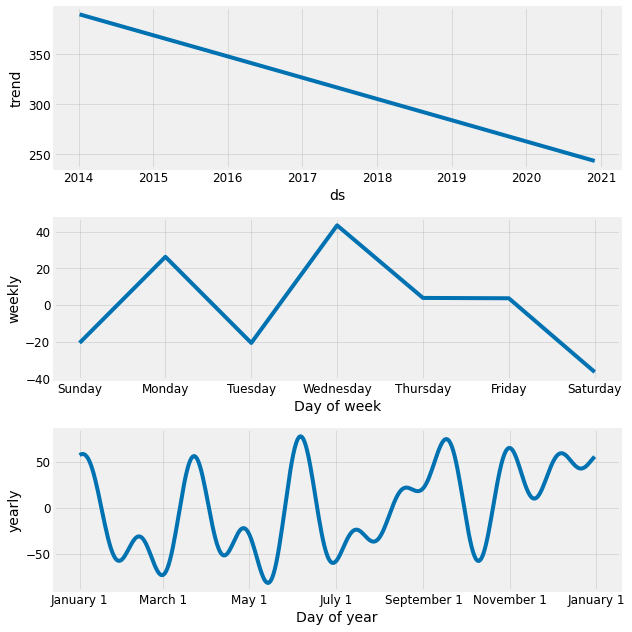

In [7]:
# Trends and Patterns
# Now, we can use the Prophet Models to inspect different trends of these 
# two categories in the data.
furniture_model.plot_components(furniture_forecast);


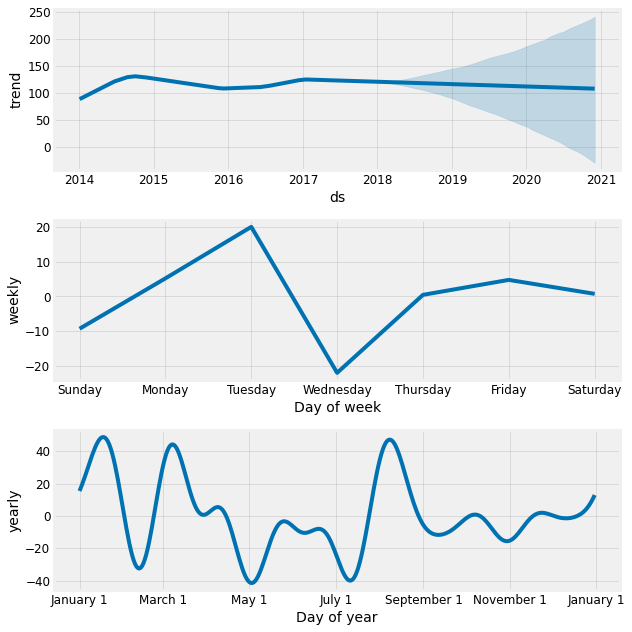

In [8]:
office_model.plot_components(office_forecast);

# Good to see that the sales for both furniture and office supplies have 
# been linearly increasing over time and will be keep growing, although 
# office supplies’ growth seems slightly stronger.
# The worst month for furniture is April, the worst month for 
# office supplies is February. The best month for furniture is December, 
# and the best month for office supplies is October.
# There are many time-series analysis we can explore from now on, such as 
# forecast with uncertainty bounds, change point and anomaly detection, 
# forecast time-series with external data source. We have only just started.
# Source code can be found on Github. I look forward to hearing 
# feedback or questions.
# References:
# A Guide to Time Series Forecasting with ARIMA in Python 3
# A Guide to Time Series Forecasting with Prophet in Python 3
# Susan Li
# Changing the world, one post at a time. 
# Sr Data Scientist, Toronto Canada. https://www.linkedin.com/in/susanli/
